## Generating Random Datasets

Generating datasets is an essential tool for testing analysis code because it allows you to verify that your code is working correctly on realistic data. When working with real-world data, there are often many sources of noise and variability, such as measurement error, missing data, and sampling variability. Testing your code on synthetic datasets with known characteristics allows you to evaluate the performance of your code under different scenarios and to ensure that your code is robust to the noise and variability that may be present in real-world data.

In addition to testing code, generating datasets can also be used for exploratory data analysis, hypothesis testing, and model selection. By generating synthetic datasets with known characteristics, you can explore the properties of different statistical models and test hypotheses about the underlying data generating process. This can help you to identify potential issues with your analysis approach, such as overfitting, and to select the most appropriate model for your data.

Overall, generating datasets is a powerful tool for testing and validating analysis code, and the functions provided above offer a simple and flexible way to generate noisy datasets for a wide range of applications.

The functions below provide a convenient way to generate noisy datasets for testing analysis code. The ```generate_noisy_dataframe``` function generates a Pandas dataframe with a specified number of rows and columns, where the values in each column are generated using an externally defined distribution function with added noise. The function also includes a random seed column that can be used for reproducibility. The ```add_column_to_dataframe``` function adds a new column to an existing dataframe using a specified distribution function with added noise. These functions provide a flexible and efficient way to generate datasets for testing machine learning and statistical analysis code.

In [1]:
import pandas as pd
import numpy as np

In [2]:
def generate_random_seed_column(n_samples: int) -> pd.Series:
    """
    Generates a column of random seed values as integers between 0 and 2**32-1 with `n_samples` entries.

    Parameters:
    n_samples: int
        The number of samples to generate.

    Returns:
    pd.Series
        A column of random seed values as integers between 0 and 2**32-1.
    """
    return pd.Series(np.random.randint(low=0, high=2**31-1, size=n_samples), name='seed')


In [62]:
def add_noisy_column(df: pd.DataFrame,
                     column_name: str,
                     distribution_function: callable, 
                     noise_function: callable, 
                     noise_factor: float) -> pd.DataFrame:
    """
    Adds a new column to a dataframe `df` generated from a specified `distribution_function` with added noise using a 
    `noise_function` and a `noise_factor`.

    Parameters:
    df: pd.DataFrame
        The dataframe to which the column should be added.
    column_name: str
        The name of the column.
    distribution_function: callable
        A function that takes a random seed value (a float between 0 and 1) and returns a sample from the desired distribution.
    noise_function: callable
        A function that takes a sample from the distribution and returns an amount of noise to add to that sample.
    noise_factor: float
        A scaling factor for the amount of noise added to each sample.

    Returns:
    pd.DataFrame
        The original dataframe with an additional noisy column.
    """
    # Generate noisy samples for the column using the specified distribution function and noise function.
    new_col = distribution_function(df['seed'].to_numpy())
    new_col = noise_function(new_col, noise_factor, df['seed'].to_numpy())

    # Add the new column to the dataframe.
    df[column_name] = new_col

    return df

In [63]:
def generate_noisy_dataframe(n_samples: int, 
                              column_names: list,
                              distribution_functions: list, 
                              noise_function: callable, 
                              noise_factors: list) -> pd.DataFrame:
    """
    Generates a pandas dataframe with `n_samples` rows and columns based on specified `distribution_functions`
    with added noise using a `noise_function` and a `noise_factor`.

    Parameters:
    n_samples: int
        The number of samples to generate for each column.
    column_names: list
        The list of names to use for the columns.
    distribution_functions: list
        A list of functions, where each function takes a random seed value (a float between 0 and 1)
        and returns a sample from a desired distribution.
    noise_function: callable
        A function that takes a sample from the distribution and returns an amount of noise to add to that sample.
    noise_factors: list
        A list of scaling factors for the amount of noise added to each sample.

    Returns:
    pd.DataFrame
        A dataframe with `n_samples` rows and columns based on specified `distribution_functions`
        with added noise using a `noise_function` and a `noise_factor`.
    """
    # Initialize an empty dataframe with a random seed column.
    df = pd.DataFrame()
    df['seed'] = generate_random_seed_column(n_samples)

    # Add noisy columns to the dataframe for each specified distribution function.
    for i, dist_func in enumerate(distribution_functions):
        df = add_noisy_column(df, column_names[i], dist_func, noise_function, noise_factors[i])

    return df

In [64]:
from typing import Union

In [65]:
def gaussian_distribution(seed: Union[float, np.ndarray], mean: float, std: float) -> np.ndarray:
    """
    Generate a sample from a Gaussian distribution with a specified mean and standard deviation.

    Parameters:
    seed (Union[float, np.ndarray]): the random seed value(s) used to generate the sample(s).
    mean (float): the mean of the Gaussian distribution.
    std (float): the standard deviation of the Gaussian distribution.

    Returns:
    np.ndarray: an array of samples from the Gaussian distribution with the specified mean and standard deviation.
    """
    # Convert single seeds to arrays for consistency.
    if isinstance(seed, float):
        seed = np.array([seed])

    # Use the seed value(s) to generate samples from the Gaussian distribution.
    np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std, size=len(seed))

In [66]:
import functools

In [67]:
def noise_func(x: np.ndarray, scale: float, seed: Union[float, np.ndarray]) -> np.ndarray:
    """
    Adds random noise to a variable x, with the amount of noise determined by the scale parameter.

    Parameters:
    x (np.ndarray): the array to which noise should be added.
    scale (float): a dimensionless parameter controlling the amount of noise to add, with 0 corresponding to no noise and 1 corresponding to maximum noise.
    seed (Union[float, np.ndarray]): a seed value or array of seed values used to generate random numbers.

    Returns:
    np.ndarray: the array x plus random noise.
    """
    return x + (np.random.RandomState(seed).rand(x.size) - 0.5) * 2 * scale * x

In [108]:
def generate_particle_values(num_particles: int) -> tuple:
    """
    Generates lists of means, standard deviations, noise factors, and names for `num_particles` particles.

    Parameters:
    num_particles: int
        The number of particles to generate values for.

    Returns:
    tuple
        A tuple of four lists:
        - means_list: a list of means for each particle, where each mean is a list of three floats
        - stds_list: a list of standard deviations for each particle, where each standard deviation is a list of three floats
        - noise_factors_list: a list of noise factors for each particle, where each noise factor is a list of three floats
        - names_list: a list of column names for each particle, where each column name is a string in the format 'particle_a_px',
                      'particle_a_py', or 'particle_a_pz', where a is the particle number (starting from 0)
        - latex_names: a dict with the latex version of each colum name.
    """
    means_list = []
    stds_list = []
    noise_factors_list = []
    names_list = []
    latex_names = {}

    # Loop over each particle
    for i in range(num_particles):
        # Generate random means, standard deviations, noise factors, and names for the particle
        particle_means = np.random.uniform(100, 200, 3).tolist()
        particle_stds = np.random.uniform(10, 30, 3).tolist()
        particle_noise_factors = np.random.uniform(0, 1, 3).tolist()
        particle_names = [f'particle_{i}_px', f'particle_{i}_py', f'particle_{i}_pz']
        particle_latex_names = {particle_names[j]: fr'$p_{{{particle_names[j][9]}}}' + fr'(p_{{{i}}})$' for j in range(3)}

        # Append the particle's values to the appropriate list
        means_list += particle_means
        stds_list += particle_stds
        noise_factors_list += particle_noise_factors
        names_list += particle_names
        latex_names.update(particle_latex_names)

    # Return the lists as a tuple
    return means_list, stds_list, noise_factors_list, names_list, latex_names

In [109]:
num_particles = 3
means, stds, noise_factors, names, latex_titles = generate_particle_values(num_particles)

print(latex_titles)

{'particle_0_px': '$p_{0}(p_{0})$', 'particle_0_py': '$p_{0}(p_{0})$', 'particle_0_pz': '$p_{0}(p_{0})$', 'particle_1_px': '$p_{1}(p_{1})$', 'particle_1_py': '$p_{1}(p_{1})$', 'particle_1_pz': '$p_{1}(p_{1})$', 'particle_2_px': '$p_{2}(p_{2})$', 'particle_2_py': '$p_{2}(p_{2})$', 'particle_2_pz': '$p_{2}(p_{2})$'}


In [110]:
# Define the distribution functions for each column using the Gaussian distribution function.
distributions = [functools.partial(gaussian_distribution, mean=mu, std=sigma) for mu, sigma in zip(means, stds)]

# Generate the dataframe with 1000 samples.
df = generate_noisy_dataframe(n_samples=10000, column_names=names, distribution_functions=distributions, noise_function=noise_func, noise_factors=noise_factors)

# Print the first few rows of the dataframe.
print(df.head())

         seed  particle_0_px  particle_0_py  particle_0_pz  particle_1_px  \
0   273767234     206.266407     255.831348     124.814973     173.638005   
1  1487633036     160.023049     175.294029     131.480918     113.333382   
2   590446677     110.300616      95.758793      94.476804      44.454453   
3  1385316263      96.651540      72.152675      94.860867      26.300531   
4   628794573     186.791259     220.496890     106.975663     135.112517   

   particle_1_py  particle_1_pz  particle_2_px  particle_2_py  particle_2_pz  
0     217.991903     191.577213     213.885195     127.533460     256.702799  
1     153.541376     149.261594     149.732097     140.165837     177.186602  
2      90.269831      96.543825      69.623040      94.908828      98.146854  
3      71.417393      83.769265      50.105559      96.524618      74.825792  
4     191.230821     168.988173     171.848023     105.163592     221.798594  


In [111]:
import matplotlib.pyplot as plt
import math

In [112]:
def plot_distributions(df: pd.DataFrame, plot_variables: list) -> None:
    """
    Plots histograms of the distributions of all columns in a dataframe.

    Parameters:
    df (pd.DataFrame)
        The dataframe to plot.
    plot_variables: list
        The list of varaibles to plot.

    Returns:
    None
    """
    # Set up the plot.
    n_cols = 3
    n_rows = math.ceil(len(plot_variables)/n_cols)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 5 * n_rows))
    
    # Loop over each column in the dataframe.
    for i, col in enumerate(plot_variables):
        nrow = int(i/n_cols)
        ncol = i%n_cols
        # Plot the histogram as a line.
        axs[nrow][ncol].hist(df[col], bins=50, density=True, histtype='step', color='black', linewidth=1)

        # Set the axis labels and title.
        axs[nrow][ncol].set_xlabel(latex_titles[col])
        axs[nrow][ncol].set_ylabel('Density')
        
        # Remove the yticks
        axs[nrow][ncol].set_yticks([])

    # Show the plot.
    plt.show()

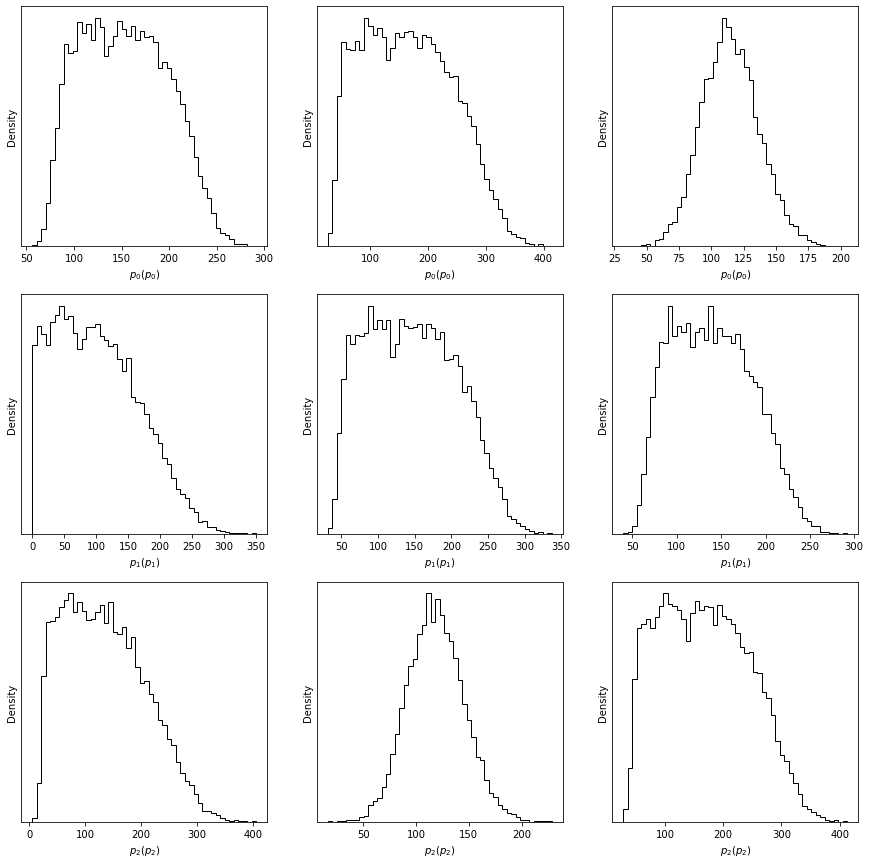

In [113]:
plot_distributions(df, latex_titles)